## Import dataset 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
plt.style.use('ggplot')
%matplotlib inline

In [3]:
df_all = pd.read_csv('DCD_April.csv')

C:\Users\zfang\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df_all.columns = [col.lower().replace(' ','_') for col in df_all.columns.tolist()]
df_all.columns = [col.lower().replace('/timestamp','') for col in df_all.columns.tolist()]

In [5]:
date_col = [col for col in df_all.columns.tolist() if 'date' in col]
df_all[date_col] = df_all[date_col].apply(pd.to_datetime,format = "%m/%d/%Y %H:%M:%S")

In [6]:
df_all.event_site_name.unique(),df_all.event_type.unique()

(array(['Nexium24hour', 'Centrum', 'Advil', 'Advil PM', 'Preparationh',
        'Emergenc', 'default'], dtype=object),
 array(['nexium24hour-buy.now', 'centrum-coupon.submit', 'sale.advil',
        'centrum-email.sign.up', 'sale.advilpm', 'sale.centrum',
        'preparationh-coupon.submit', 'preparationh-buy.now', 'sale.nexium',
        'preparationh-email.sign.up', 'advil pm-buy.now', 'advil-buy.now',
        'emergenc-buy.now', 'centrum-buy.now', 'sale.preparationh',
        'emergenc-coupon.submit', 'emergenc-email.sign.up',
        'emergenc-add.to.cart', 'sale.emergenc',
        'emergenc-freesample.submit', 'advil-coupon.submit',
        'advil-email.sign.up', 'nexium24hour-coupon.submit',
        'nexium24hour-email.sign.up', 'advil pm-coupon.submit',
        'advil pm-email.sign.up', 'nexium24hour-sweepstakes.social.share',
        'nexium24hour-sweepstakes.submit', 'emergenc-sale.online'], dtype=object))

In [7]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253319 entries, 0 to 1253318
Data columns (total 22 columns):
unique_row_id           1253319 non-null object
cvo_sid                 1253319 non-null object
event_site_id           1253319 non-null int64
touchpoint_site_id      1253319 non-null int64
event_site_name         1253319 non-null object
touchpoint_site_name    1253319 non-null object
event_type              1253319 non-null object
event_id                1253319 non-null object
event_date              1253319 non-null datetime64[ns]
touchpoint_date         1253319 non-null datetime64[ns]
total_event_value       1253319 non-null float64
touchpoint_revenue      1253319 non-null float64
conversion              1253319 non-null float64
touchpoint_type         1027602 non-null object
first_touch_date        1253319 non-null datetime64[ns]
last_touch_date         1253319 non-null datetime64[ns]
source_1                1253319 non-null object
source_2                1253319 non-nu

## frequency on sales

conversion window 30days

continous window 14 days

max path length 30

event sales

sourse 1 not base


In [8]:
sale_df = df_all[df_all.event_type.str.contains('sale')]

In [9]:
sale_df = sale_df[sale_df.source_1!='base']

sale_df['touch_to_last'] = (sale_df.event_date-sale_df.touchpoint_date).dt.days

df_sale_convwin = sale_df[sale_df.touch_to_last<30]

In [10]:
df_sale_fre = pd.DataFrame({'count':df_sale_convwin.groupby('event_id')['event_id'].count()}).reset_index()

In [11]:
df_sale_fre_count = df_sale_fre.groupby('count')['count'].count().sort_index()[:30]

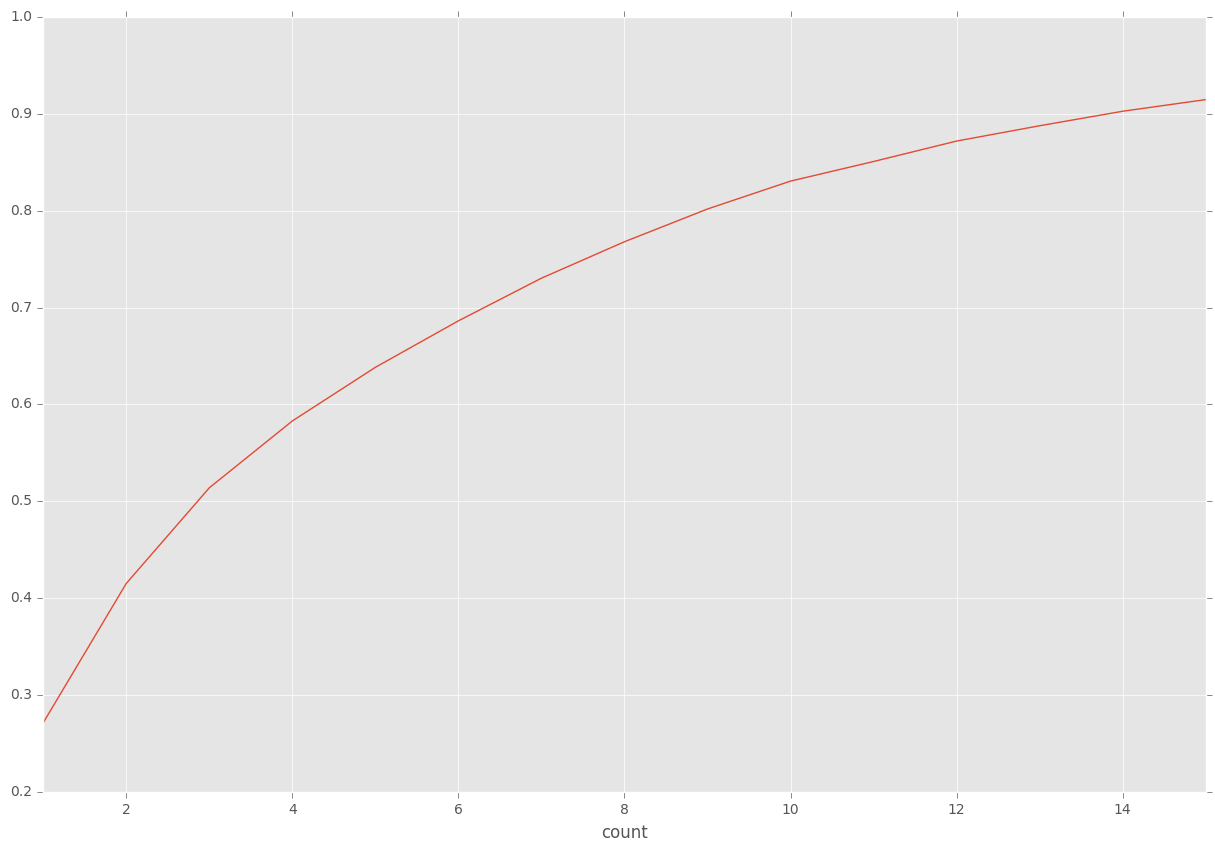

In [12]:
(df_sale_fre_count/df_sale_fre_count.sum()).cumsum()[:15].plot(figsize = (15,10))

## Feature Engineering

In [13]:
df_nobase=df_all[df_all['source_1']!='base']

In [14]:
df_nobase.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1027602 entries, 0 to 1253318
Data columns (total 22 columns):
unique_row_id           1027602 non-null object
cvo_sid                 1027602 non-null object
event_site_id           1027602 non-null int64
touchpoint_site_id      1027602 non-null int64
event_site_name         1027602 non-null object
touchpoint_site_name    1027602 non-null object
event_type              1027602 non-null object
event_id                1027602 non-null object
event_date              1027602 non-null datetime64[ns]
touchpoint_date         1027602 non-null datetime64[ns]
total_event_value       1027602 non-null float64
touchpoint_revenue      1027602 non-null float64
conversion              1027602 non-null float64
touchpoint_type         1027602 non-null object
first_touch_date        1027602 non-null datetime64[ns]
last_touch_date         1027602 non-null datetime64[ns]
source_1                1027602 non-null object
source_2                1027602 non-nu

In [15]:
selected_col=['event_site_name','event_type','conversion','touchpoint_type','source_1','touchpoints_in_path','attribution_sequence','path_position']

In [16]:
df_col=[x for x in df_nobase.columns.tolist() if x in selected_col]

df_col.extend(date_col)

In [17]:
df_col

['event_site_name',
 'event_type',
 'conversion',
 'touchpoint_type',
 'source_1',
 'touchpoints_in_path',
 'attribution_sequence',
 'path_position',
 'event_date',
 'touchpoint_date',
 'first_touch_date',
 'last_touch_date']

In [18]:
df_model=df_nobase[df_col]

In [19]:
df_model.head()

,event_site_name,event_type,conversion,touchpoint_type,source_1,touchpoints_in_path,attribution_sequence,path_position,event_date,touchpoint_date,first_touch_date,last_touch_date
0,Nexium24hour,nexium24hour-buy.now,1.000000,visit,ppc nonbrand,1,1,only,2017-04-07 17:54:58,2017-04-07 17:54:58,2017-04-07 17:54:58,2017-04-07 17:54:58
2,Centrum,centrum-coupon.submit,0.000047,visit,organic not provided,2,1,introducer,2017-04-21 17:52:51,2017-04-12 12:26:32,2017-04-12 12:26:32,2017-04-21 17:52:51
3,Centrum,centrum-coupon.submit,0.011891,visit,organic not provided,2,2,closer,2017-04-21 17:52:51,2017-04-21 17:50:56,2017-04-12 12:26:32,2017-04-21 17:52:51
7,Centrum,centrum-coupon.submit,0.197314,visit,ppc brand,1,1,only,2017-04-30 18:04:52,2017-04-30 18:04:22,2017-04-30 18:04:22,2017-04-30 18:04:52
8,Centrum,centrum-email.sign.up,1.000000,visit,social network paid,1,1,only,2017-04-19 14:12:59,2017-04-19 14:12:00,2017-04-19 14:12:00,2017-04-19 14:12:00


In [37]:
df_model.groupby('source_1').source_1.count()

source_1
content                  18998
coupon                   11957
display                 726649
ecrm                       102
email                     6028
influencer                 311
organic brand             1461
organic nonbrand           197
organic not provided     22413
other                    15354
pchbrands                   93
ppc brand                36791
ppc content                  8
ppc nonbrand              7640
social n etwork paid       536
social n etworkpaid          4
social network            9324
social network  paid       244
social network paid       4813
text                       215
video                   164463
zalo                         1
Name: source_1, dtype: int64

In [38]:
df_model['source_1'].replace({'social n etwork paid': 'social network paid',
                              'social n etworkpaid':'social network paid',
                              'social network  paid':'social network paid',
                              'pchbrands':'ppc brand'},inplace=True)

C:\Users\zfang\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\generic.py:3554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [39]:
df_model.groupby('source_1').source_1.count()

source_1
content                  18998
coupon                   11957
display                 726649
ecrm                       102
email                     6028
influencer                 311
organic brand             1461
organic nonbrand           197
organic not provided     22413
other                    15354
ppc brand                36884
ppc content                  8
ppc nonbrand              7640
social network            9324
social network paid       5597
text                       215
video                   164463
zalo                         1
Name: source_1, dtype: int64

In [40]:
df_model['event_to_touchpoint']=(df_model.event_date-df_model.touchpoint_date).dt.total_seconds()

C:\Users\zfang\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


(array([  4.09192000e+05,   1.44245000e+05,   1.00133000e+05,
          9.37340000e+04,   8.42980000e+04,   6.28760000e+04,
          7.06750000e+04,   5.61630000e+04,   6.01700000e+03,
          2.69000000e+02]),
 array([        0. ,   1311754.9,   2623509.8,   3935264.7,   5247019.6,
          6558774.5,   7870529.4,   9182284.3,  10494039.2,  11805794.1,
         13117549. ]),
 <a list of 10 Patch objects>)

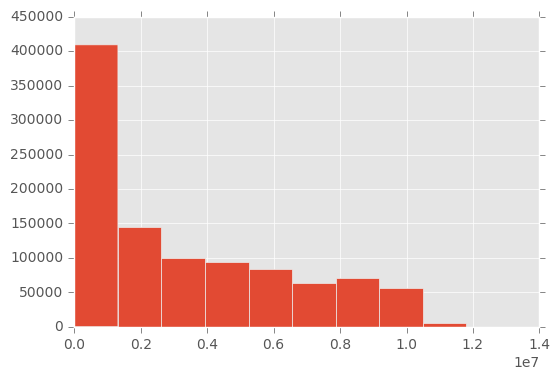

In [41]:
plt.hist(df_model['event_to_touchpoint'])

In [42]:
df_model['event_to_touchpoint']=df_model['event_to_touchpoint']+1

C:\Users\zfang\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [43]:
df_model['log_event_to_touchpoint']=np.log(df_model['event_to_touchpoint'])

C:\Users\zfang\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [44]:
df_model['log_event_to_touchpoint'].head()

0     0.000000
2    13.588836
3     4.753590
7     3.433987
8     4.094345
Name: log_event_to_touchpoint, dtype: float64

In [45]:
df_model['day_of_week']=df_model.touchpoint_date.dt.weekday_name

C:\Users\zfang\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [46]:
df_model['month']=df_model.touchpoint_date.dt.month

C:\Users\zfang\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [47]:
df_model['week_of_month']=(df_model.touchpoint_date.dt.day-1)//7+1

C:\Users\zfang\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [48]:
df_model.drop('event_to_touchpoint',inplace=True,axis=1)

C:\Users\zfang\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [49]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1027602 entries, 0 to 1253318
Data columns (total 16 columns):
event_site_name            1027602 non-null object
event_type                 1027602 non-null object
conversion                 1027602 non-null float64
touchpoint_type            1027602 non-null object
source_1                   1027602 non-null object
touchpoints_in_path        1027602 non-null int64
attribution_sequence       1027602 non-null int64
path_position              1027602 non-null object
event_date                 1027602 non-null datetime64[ns]
touchpoint_date            1027602 non-null datetime64[ns]
first_touch_date           1027602 non-null datetime64[ns]
last_touch_date            1027602 non-null datetime64[ns]
log_event_to_touchpoint    1027602 non-null float64
day_of_week                1027602 non-null object
month                      1027602 non-null int64
week_of_month              1027602 non-null int64
dtypes: datetime64[ns](4), float64(2), in

## Get Dummies

In [50]:
df_dummies=pd.get_dummies(df_model,columns=['event_site_name','event_type','touchpoint_type','source_1','path_position','day_of_week','month','week_of_month'],
                          drop_first=True)

In [51]:
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1027602 entries, 0 to 1253318
Data columns (total 78 columns):
conversion                                          1027602 non-null float64
touchpoints_in_path                                 1027602 non-null int64
attribution_sequence                                1027602 non-null int64
event_date                                          1027602 non-null datetime64[ns]
touchpoint_date                                     1027602 non-null datetime64[ns]
first_touch_date                                    1027602 non-null datetime64[ns]
last_touch_date                                     1027602 non-null datetime64[ns]
log_event_to_touchpoint                             1027602 non-null float64
event_site_name_Advil PM                            1027602 non-null uint8
event_site_name_Centrum                             1027602 non-null uint8
event_site_name_Emergenc                            1027602 non-null uint8
event_site_name_Nexium

## Model Creation 

In [52]:
import os

In [53]:
#environment for xgboost
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.1.0-posix-seh-rt_v5-rev0\\mingw64\\bin'

os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']


In [98]:
from xgboost import XGBRegressor

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import (Ridge, TheilSenRegressor, RANSACRegressor, HuberRegressor)

from sklearn.ensemble import (RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor,
                              AdaBoostRegressor, GradientBoostingRegressor)
from sklearn.neighbors import (KNeighborsRegressor)
from sklearn.tree import DecisionTreeRegressor 
import xgboost as xgb

### Ridge 

In [56]:
#drop column with date
df_dummies=df_dummies.drop(df_dummies[date_col],axis=1)

In [57]:
target = df_dummies.conversion
df_dummies.drop('conversion',axis=1,inplace=True)

In [58]:
from sklearn.cross_validation import train_test_split

C:\Users\zfang\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [59]:
df_train,df_test,target_train,target_test = train_test_split(df_dummies,target,test_size=0.2)

In [60]:
from sklearn import metrics

In [61]:
from sklearn.linear_model import Ridge,Lasso
alg=Ridge(alpha=0.05,normalize=True)

In [62]:
alg.fit(df_train,target_train)

Ridge(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

In [63]:
metrics.mean_squared_error(target_test,alg.predict(df_test))

0.011560833776528071

In [64]:
predict = alg.predict(df_test)

In [65]:
predict

array([-0.00633304, -0.00399121, -0.00131714, ..., -0.00898369,
       -0.00897612, -0.00651716])

In [66]:
df_test.reset_index(drop=True, inplace=True)

In [67]:
pd.DataFrame([target_test.values,predict]).T.head()

,0,1
0,0.000110,-0.006333
1,0.001278,-0.003991
2,0.000001,-0.001317
3,0.053701,-0.000326
4,0.000003,0.004099


In [68]:
from sklearn.cross_validation import KFold,cross_val_score,train_test_split

In [69]:
kf=KFold(len(df_dummies),n_folds=10,
         shuffle=True,random_state=0)


In [70]:
print (cross_val_score(alg,df_dummies,target,
               cv=kf,scoring='neg_mean_squared_error').mean())

-0.0115761624188


### Random Forest 

In [71]:
from sklearn.ensemble import RandomForestRegressor

In [72]:
rf=RandomForestRegressor(n_estimators=52,max_depth=None,n_jobs=-1)

In [73]:
rf.fit(df_train,target_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=52, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [74]:
predict1=rf.predict(df_test)

In [75]:
metrics.mean_squared_error(target_test,predict1)

0.0086459644691454039

In [76]:
pd.DataFrame([target_test.values,predict1])

,0,1,2,3,4,5,6,7,8,9,...,205511,205512,205513,205514,205515,205516,205517,205518,205519,205520
0,0.000110,0.001278,0.000001,0.053701,0.000003,0.000001,0.003042,0.048383,0.002340,0.000088,...,0.001574,0.000000,0.164261,0.000014,0.000001,0.000535,0.000001,0.000904,0.009321,0.002339
1,0.000038,0.002901,0.000148,0.039957,0.000970,0.010250,0.004214,0.006582,0.001387,0.000215,...,0.007166,0.022643,0.100202,0.001168,0.001258,0.003061,0.000524,0.000893,0.003931,0.001757


* Get the best Random Forest

In [77]:
#n_trees=range(50,55)
#n_scores= []
#for n in n_trees:
#    rf=RandomForestRegressor(n_estimators=n,max_depth=10)
#    rf.fit(df_train,target_train)
#    score=metrics.mean_squared_error(target_test,rf.predict(df_test))
#    n_scores.append(score)

In [78]:
#plt.plot(n_trees,n_scores)
#plt.xlabel('Value of Trees for Random Forest')
#plt.ylabel('Random Forest Mean Squared Error')

In [79]:
#scores=cross_val_score(rf,df_dummies,target,cv=2,scoring='neg_mean_squared_error')

In [80]:
#scores

In [81]:
rf.score(df_test,target_test)

0.65102295303443236

### Decision Tree 

In [82]:
from sklearn.tree import DecisionTreeRegressor

In [83]:
dt=DecisionTreeRegressor(max_depth=40)

In [84]:
dt.fit(df_train,target_train)

DecisionTreeRegressor(criterion='mse', max_depth=40, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [85]:
predict2 = dt.predict(df_test)

In [86]:
metrics.mean_squared_error(target_test,predict2)

0.013819363590343107

In [87]:
dt.score(df_test,target_test)

0.44220905441933783

### Elastic Net

In [88]:
elastic=ElasticNet(alpha=0.1,l1_ratio=0.1)

In [89]:
elastic.fit(df_train,target_train)

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.1,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [90]:
predict2 = elastic.predict(df_test)

In [91]:
metrics.mean_squared_error(target_test,predict2)

0.016174085188107604

In [92]:
elastic.score(df_test,target_test)

0.34716543117216525

### GBR

In [93]:
gbr=GradientBoostingRegressor(n_estimators=52,learning_rate=0.1,max_depth=5,subsample=0.8)

In [94]:
gbr.fit(df_train,target_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=52, presort='auto',
             random_state=None, subsample=0.8, verbose=0, warm_start=False)

In [95]:
predict3=gbr.predict(df_test)

In [96]:
metrics.mean_squared_error(target_test,predict3)

0.0091534109783051217

In [97]:
gbr.score(df_test,target_test)

0.63054089057725826

### XGBoost 

In [99]:
xgboost=XGBRegressor()

In [100]:
xgboost.fit(df_train,target_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=1, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1)

In [101]:
predict4=xgboost.predict(df_test)

In [103]:
metrics.mean_squared_error(target_test,predict4)

0.0095035068452969315

In [104]:
xgboost.score(df_test,target_test)

0.61640997178229262